# Flow direction data

The `FlwdirRaster` object is at the core of the pyflwdir package.
It contains gridded flow direction data, parsed to an actionable common format
which describes the linear index of the next dowsntream cell.

Currently we support two local flow direction (D8) data types according to the arcgis **D8** and pcraster **LDD** conventions (see figure), and one global flow direction type according to the CaMa-Flood **NEXTXY** convention. Local flow direction data types describe the next downstream cell based on a relative direction from a cell towards one of its neighboring cells, while global flow direction types describe the next downstream cell based on its row and column indices. 

<!-- ![](../docs/_static/ftypes.png "Local flow direction types") -->
<img src="../docs/_static/ftypes.png" width="500"/>

We read the flow direction raster data, including meta-data, using [rasterio](https://rasterio.readthedocs.io/en/latest/)

In [1]:
import rasterio

with rasterio.open("rhine_d8.tif", "r") as src:
    flwdir = src.read(1)
    transform = src.transform
    crs = src.crs
    latlon = crs.to_epsg() == 4326

Next, we parse this data to a `FlwdirRaster` object, the core object 
to work with flow direction data. In this step the D8 data is parsed to an actionable format.

<div class="alert alert-info">

NOTE: that for most methods a first call might be a bit slow as the numba code is compiled just in time, a second call of the same methods (also with different arguments) will be much faster!
    
</div>


In [2]:
import pyflwdir

flw = pyflwdir.from_array(
    flwdir, ftype="d8", transform=transform, latlon=latlon, cache=True
)

In [3]:
# When printing the FlwdirRaster instance we see its attributes.
print(flw)

{'ftype': 'd8',
 'idxs_ds': array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
 'idxs_pit': array([20994], dtype=int32),
 'idxs_seq': None,
 'latlon': True,
 'nnodes': 349847,
 'shape': (682, 997),
 'transform': Affine(0.008333333333325754, 0.0, 3.5666666664997138,
       0.0, -0.008333333333339965, 52.00833333330708)}


We can than make use of the many methods of the `FlwdirRaster` object, see 
[FlwdirRaster API](reference.rst).

To visualize the flow directions we derive the stream network as vector using the [streams()](reference.rst#pyflwdir.FlwdirRaster.streams) method.
Each line element respresnets a stream segment with a minimal Strahler stream order of `min_sto`, as computed by [stream_order()](reference.rst#pyflwdir.FlwdirRaster.stream_order).
The line elements (geo features) are parsed to a [GeoDataFrame](https://geopandas.org/data_structures.html#geodataframe) object for visualization.

In [4]:
import geopandas as gpd

feats = flw.streams(min_sto=4)
gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)
gdf.head()

,geometry,idx,idx_ds,pit,strord
0,"LINESTRING (8.79583 46.57917, 8.80417 46.58750...",649674,635723,False,4
1,"LINESTRING (8.71250 46.65417, 8.72083 46.66250...",640691,635723,False,4
2,"LINESTRING (8.17917 46.57083, 8.18750 46.57083...",650597,634651,False,4
3,"LINESTRING (8.88750 46.77917, 8.88750 46.77083...",625757,632737,False,4
4,"LINESTRING (8.85417 46.69583, 8.86250 46.69583...",635723,632737,False,5


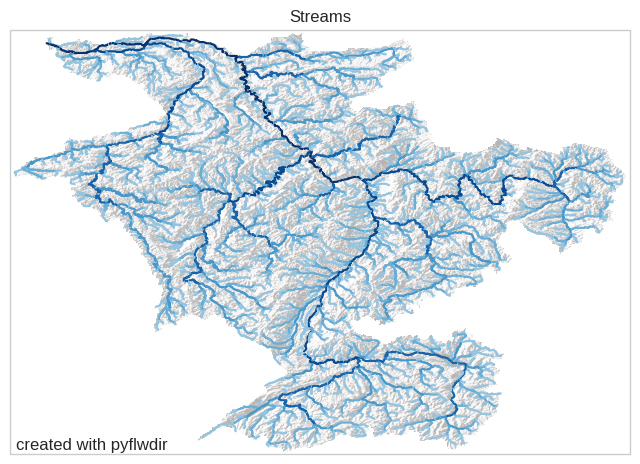

In [5]:
# plot
import numpy as np

# local convenience methods (see utils.py script in notebooks folder)
from utils import quickplot, colors, cm  # data specific quick plot method

# key-word arguments passed to GeoDataFrame.plot method
gdf_plot_kwds = dict(
    column="strord", cmap=colors.ListedColormap(cm.Blues(np.linspace(0.4, 1, 7)))
)
# plot streams with hillshade from elevation data (see utils.py)
ax = quickplot(gdfs=[(gdf, gdf_plot_kwds)], title="Streams")